In [1]:

import os, sys
sys.path.append('..')

import matplotlib.pyplot as plt
import torch
import seaborn as sns
import pandas as pd
import polars as pl
import dask.array as da
from tqdm import tqdm
from utils.mmap_dataset import MMapIndexedDataset

from dask_jobqueue import SLURMCluster
from dask.distributed import Client
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
from transformers import GPTNeoXForCausalLM, AutoTokenizer
import numpy as np


In [2]:
cluster = SLURMCluster(cores=8,
                    processes=4,
                    memory="32GB",
                    walltime="48:00:00",
                    # project="fiete",
                    queue="normal",
                    job_extra_directives=["--output=../logs/%j.out", "--error=../logs/%j.out"]
                    )
cluster.scale(jobs=8)
print("Dashboard: ", cluster.dashboard_link)

client = Client(cluster)
client

Dashboard:  http://172.16.20.123:8787/status


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: http://172.16.20.123:8787/status,
Dashboard: http://172.16.20.123:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.20.123:41633,Workers: 0
Dashboard: http://172.16.20.123:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [4]:
analysis = pd.read_parquet('../results/analysis.parquet.gzip')
analysis

longest_match  overlap  lev  diff       0  10  20  30  \
index    checkpoint                                                          
10240000 10000                   0        9   53   3.0  475130   1   1   1   
         11000                   0        7   56  -1.0  476660   0   0   0   
         12000                   0        8   55   0.0  475581   0   0   0   
         13000                   0        8   55   4.0  476449   0   0   0   
         14000                   0        4   59  -3.0  477157   0   0   0   
...                            ...      ...  ...   ...     ...  ..  ..  ..   
11263980 15000                   7        7   54   1.0  358855   0   0   0   
         16000                   7        7   55   0.0  358432   0   0   0   
         17000                   7        8   55   1.0  358371   0   0   0   
         18000                   7        7   56  -3.0  359408   0   0   0   
         19000                   7        8   53   3.0  345345   0   0   0   

                     40  50  ...  180  190  200  210  220  230  240  250  \
index    checkpoint          ...                                           
10240000 10000        1   1  ...    1    1    1    1    1    1    1    1   
         11000        0   0  ...    0    0    0    0    0    0    0    0   
         12000        0   0  ...    0    0    0    0    0    0    0    0   
         13000        0   0  ...    0    0    0    0    0    0    0    0   
         14000        0   0  ...    0    0    0    0    0    0    0    0   
...                  ..  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...   
11263980 15000        0   0  ...    0    0    0    0    0    0    0    0   
         16000        0   0  ...    0    0    0    0    0    0    0    0   
         17000        0   0  ...    0    0    0    0    0    0    0    0   
         18000        0   0  ...    0    0    0    0    0    0    0    0   
         19000        0   0  ...    0    0    0    0    0    0    0    0   

                     complexity  cumsum30  
index    checkpoint                        
10240000 10000         0.593750         1  
         11000         0.593750         1  
         12000         0.593750         1  
         13000         0.593750         1  
         14000         0.593750         1  
...                         ...       ...  
11263980 15000         0.538194         1  
         16000         0.538194         1  
         17000         0.538194         1  
         18000         0.538194         1  
         19000         0.538194         1  

[512000 rows x 32 columns]

### Memorization

In [6]:
["index"] + [f"match{2**i}" for i in range(0, 9)]
all_dfs = []
for i in range(10000, 19001, 1000):
    df = pl.scan_csv(f"../results/memorization-dyn-count/evals-running/memorization_1b-v0_{i}_10240000/*.csv", has_header=False, 
            new_columns = ["index", "longest_match", "overlap"])
    # df["index"] = df["index"].cast(pl.Int64)
    df = df.with_columns(checkpoint = pl.lit(i))
    all_dfs.append(df)
df = pl.concat(all_dfs)

Text(0.5, 0, 'Checkpoint')

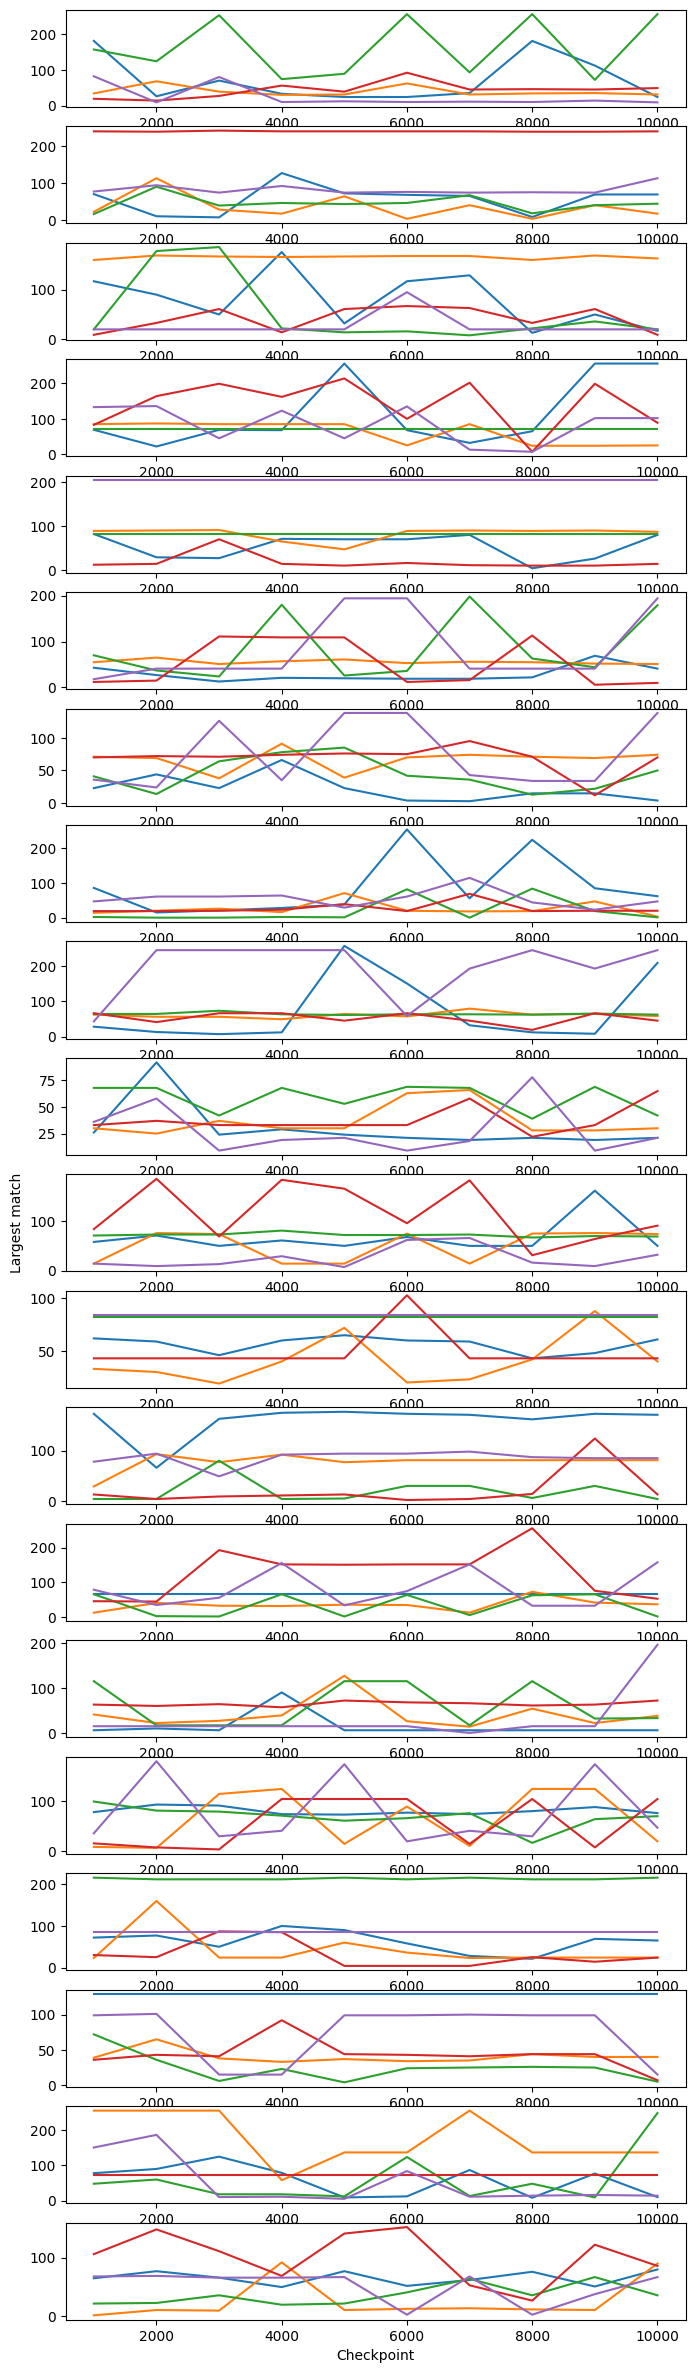

In [7]:
mem_indices = df.filter(pl.col("overlap") > 64).select("index").collect()
mem_seq = df.filter(pl.col("index").is_in(mem_indices) & (pl.col("index") % 20 == 0)).collect()
dyn = mem_seq.select("index", "checkpoint", "overlap").pivot("overlap", "index", "checkpoint", aggregate_function="mean").drop_nulls()
f, ax = plt.subplots(20, figsize=(8, 30))
for i in range(100):
    ax[i//5].plot(range(1000, 10001, 1000), dyn.to_numpy()[i, 1:].T);
    
    ax[i//5].set()
ax[10].set(ylabel="Largest match")
ax[-1].set_xlabel("Checkpoint")

In [8]:
matches = []
for i in range(203):
    matches.append(da.from_npy_stack(f'/om/tmp/memorization/matches-count-a2a-opt-10k/{i}/'))
m = da.concatenate(matches, axis=1)

In [9]:

mem_seq = df.filter((pl.col("index") % 20 == 0)).collect()
df = mem_seq.select("index", "checkpoint", "overlap").pivot("overlap", "index", "checkpoint", aggregate_function="mean").drop_nulls().to_pandas()
# df["index"] += 10000 * 1024

### Load Dataset + Model

In [10]:
dataset = MMapIndexedDataset('/om/user/sunnyd/data/datasets--EleutherAI--pile-standard-pythia-preshuffled-merged/document', skip_warmup = True)
tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="/om/user/sunnyd/transformers_cache",
)

MODEL='1b-v0'
CHECKPOINT=8000
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{MODEL}",
    use_cache=False,
    revision = f'step{CHECKPOINT}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
).eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...


(array([5.5000e+02, 5.8100e+03, 1.4660e+04, 3.0520e+04, 4.5260e+04,
        7.4340e+04, 1.7453e+05, 1.5153e+05, 1.4640e+04, 1.6000e+02]),
 array([0.00694444, 0.09027778, 0.17361111, 0.25694444, 0.34027778,
        0.42361111, 0.50694444, 0.59027778, 0.67361111, 0.75694444,
        0.84027778]),
 <BarContainer object of 10 artists>)

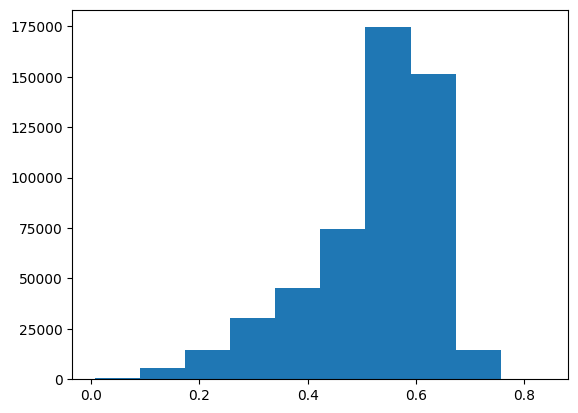

In [11]:
plt.hist(analysis["complexity"])

In [12]:
indices = (analysis["longest_match"] > 30) & (analysis["complexity"] > 0.6)
np.sum(indices)

79

# Analyze Sequences

In [13]:
indices = (analysis["longest_match"] > 30) & (analysis["cumsum30"] == 1) & (analysis["complexity"] > 0.6) & (analysis.index.get_level_values(1) > 10000)

In [14]:
df1 = analysis.loc[indices]
df1 = df1[df1.groupby("index")["longest_match"].transform(max) == df1["longest_match"]]
df1 = df1.groupby("index").first()
df1

/tmp/ipykernel_2094972/2617840593.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df1 = df1[df1.groupby("index")["longest_match"].transform(max) == df1["longest_match"]]


,longest_match,overlap,lev,diff,0,10,20,30,40,50,...,180,190,200,210,220,230,240,250,complexity,cumsum30
index,,,,,,,,,,,,,,,,,,,,,
10579600,42,42,17,17.0,155965,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.635417,1
10835120,60,62,2,4.0,2886,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.614583,1
11067280,34,35,29,1.0,77728,30,19,0,0,0,...,0,0,0,0,0,0,0,0,0.607639,1


In [15]:
idx = 11067280
context_tokens = torch.tensor([dataset[idx][:32].astype(np.int32)])



/tmp/ipykernel_2094972/1958005891.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  context_tokens = torch.tensor([dataset[idx][:32].astype(np.int32)])


In [16]:
CHECKPOINT = 10000
gens = []
for ckpt in range(10000, 20000, 1000):
    model = GPTNeoXForCausalLM.from_pretrained(
        f"EleutherAI/pythia-{MODEL}",
        use_cache=False,
        revision = f'step{ckpt}',
        cache_dir=f"/om/user/sunnyd/transformers_cache/"
    ).eval().cuda()
    with torch.no_grad():
        gens.append(model.generate(context_tokens.cuda(), temperature = 0.0, top_k = 0, top_p = 0, max_length = 288, min_length = 288))


# gen = (tokenizer.decode(dataset[idx][:32]), 
#  tokenizer.decode(dataset[idx][32:288]), 
#  tokenizer.decode(generations[0][32:])
# )

/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(
/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:407: UserWarning: `do_sample` is set to `False`. However, `top_k` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_k`.
  warnings.warn(
The attention mask and 

In [45]:
import html
true_cont = tokenizer.decode(dataset[idx][32:255])
cols = [
    f"""<td><div>{html.escape(tokenizer.decode(dataset[idx][:32]))}</div></td><td><div>{html.escape(true_cont)}</div></td>"""
       ]
for g in gens:
    cur_str = tokenizer.decode(g[0][32:])
    index = next((i for i in range(min(len(cur_str), len(true_cont))) if cur_str[i]!=true_cont[i]), None)
    print(index)
    cols.append(
    f"""<td><div><span style="color: #ff0000">{html.escape(cur_str[:index])}</span>{html.escape(cur_str[index:])}</div></td>""")
enc = f"""
<style>
table td {{
    border: 0;
    position: relative
}}

textarea {{
    border: none;
    height: 500px;
    width: 100%;
    -webkit-box-sizing: border-box; /* <=iOS4, <= Android  2.3 */
    -moz-box-sizing: border-box; /* FF1+ */
    box-sizing: border-box; /* Chrome, IE8, Opera, Safari 5.1*/
}}
</style>

<table>
    <colgroup>
        <col style="width: 200px;">  <!-- Setting the width of the first column -->
        <col style="width: 200px;">  <!-- Auto width for the second column -->
        <col style="width: 200px;">  <!-- Auto width for the second column -->
        <col style="width: 200px;">  <!-- Auto width for the second column -->
        <col style="width: 200px;">  <!-- Setting the width of the first column -->
        <col style="width: 200px;">  <!-- Auto width for the second column -->
        <col style="width: 200px;">  <!-- Auto width for the second column -->
        <col style="width: 200px;">  <!-- Auto width for the second column -->
        <col style="width: 200px;">  <!-- Auto width for the second column -->
        <col style="width: 200px;">  <!-- Auto width for the second column -->
    </colgroup>
    <tr>
        <th>Context</th>
        <th>True Continuation</th>
        <th>Model Continuation</th>
    </tr>
    <tr>
    {cols}
    </tr>

</table>
"""
from IPython.core.display import display, HTML
display(HTML(enc))

150
116
126
0
1
116
166
150
50
116


/tmp/ipykernel_2386091/4212307540.py:53: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


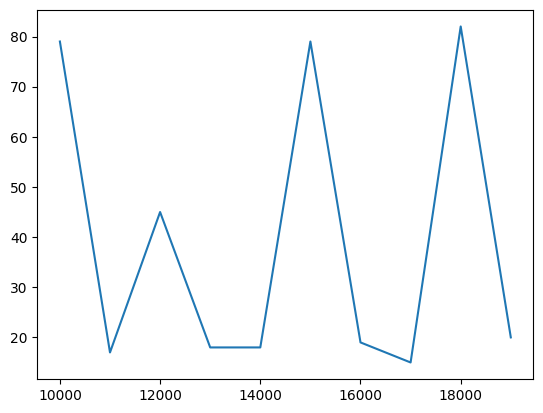

In [18]:
plt.plot(df[df["index"] == idx].iloc[0, 1:].index.astype(int), df[df["index"] == idx].iloc[0, 1:].to_numpy())


# single sequences

100%|██████████| 3/3 [06:40<00:00, 133.61s/it]


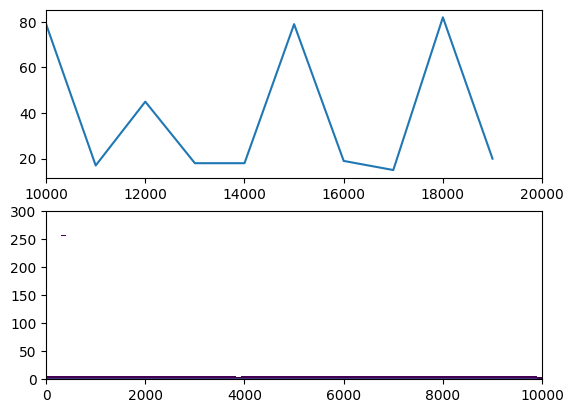

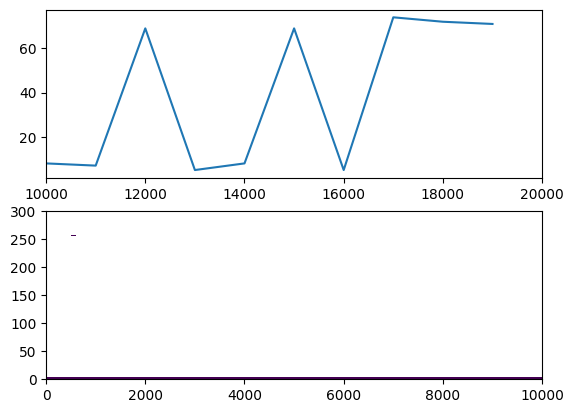

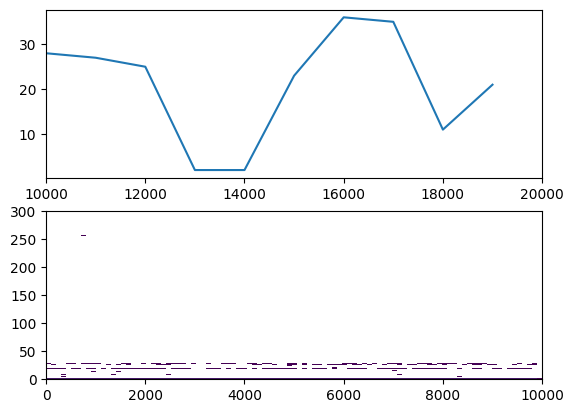

In [11]:
for idx in tqdm(df1.index):
    match_0 = m[(idx - 10000 * 1024) // 20, :].compute()

    f, ax = plt.subplots(2, 1)
    # ax.hist2d(np.arange(len(match_0)) / 1024, match_0.T, norm='log', bins=100);
    # ax2 = ax.twinx() 
    ax[0].plot(df[df["index"] == idx].iloc[0, 1:].index.astype(int), df[df["index"] == idx].iloc[0, 1:].to_numpy())
    ax[0].set(xlim=(10000, 20000))
    ax[1].hist2d(np.arange(len(match_0)) / 1024, match_0.T, 
               bins=(np.linspace(0, 10000, 100), np.linspace(0, 300, 301)), 
               cmin = 1
              );

    f.savefig(f"images/{idx}.png");

In [12]:
df1 = analysis.loc[(analysis["longest_match"] > 30) & (analysis["cumsum30"] == 1) & (analysis["complexity"] > 0.6) & (analysis.index.get_level_values(1) > 10000)].reset_index()
df1 = df1[df1.groupby("index")["longest_match"].transform(max) == df1["longest_match"]]
df1 = df1.groupby("index").first()
df1

/tmp/ipykernel_457842/1068811682.py:2: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df1 = df1[df1.groupby("index")["longest_match"].transform(max) == df1["longest_match"]]


,checkpoint,longest_match,overlap,diff,0,10,20,30,40,50,...,180,190,200,210,220,230,240,250,complexity,cumsum30
index,,,,,,,,,,,,,,,,,,,,,
10579600,15000,77,79,-61.0,155566,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.635417,1
10835120,12000,60,69,-60.0,2886,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.614583,1
11067280,16000,34,36,0.0,77728,30,19,0,0,0,...,0,0,0,0,0,0,0,0,0.607639,1


In [13]:
rows = []
for idx, row in tqdm(df1.iterrows()):
    CHECKPOINT = int(row.checkpoint)
    context_tokens = torch.tensor([dataset[idx][:32].astype(np.int32)])

    model = GPTNeoXForCausalLM.from_pretrained(
        f"EleutherAI/pythia-{MODEL}",
        use_cache=False,
        revision = f'step{CHECKPOINT}',
        cache_dir=f"/om/user/sunnyd/transformers_cache/"
    ).eval().cuda()
    with torch.no_grad():
        generations = model.generate(context_tokens.cuda(), temperature = 0.0, top_k = 0, top_p = 0, max_length = 288, min_length = 288)


    rows.append(f"""
        <tr>
        <td><img src="images/{idx}.png" width="500"></td>
        <td><textarea>{tokenizer.decode(dataset[idx][:32])}</textarea></td>
        <td><textarea>{tokenizer.decode(dataset[idx][32:288])}</textarea></td>
        <td><textarea>{tokenizer.decode(generations[0][32:])}</textarea></td>
    </tr>
    """)



0it [00:00, ?it/s]/tmp/ipykernel_457842/532447907.py:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  context_tokens = torch.tensor([dataset[idx][:32].astype(np.int32)])
/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/om2/user/sunnyd/anaconda/envs/pythia/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=T

In [19]:
body = "\n".join(rows)

In [20]:
%%capture cap
from IPython.display import HTML, display
# HTML to embed the image in a table with text
html = f"""
<style>
table td {{
    border: 0;
    position: relative
}}

textarea {{
    border: none;
    height: 500px;
    width: 100%;
    -webkit-box-sizing: border-box; /* <=iOS4, <= Android  2.3 */
    -moz-box-sizing: border-box; /* FF1+ */
    box-sizing: border-box; /* Chrome, IE8, Opera, Safari 5.1*/
}}
</style>

<table>
    <colgroup>
        <col style="width: 300px;">  <!-- Setting the width of the first column -->
        <col style="width: 300px;">  <!-- Auto width for the second column -->
        <col style="width: 300px;">  <!-- Auto width for the second column -->
        <col style="width: 300px;">  <!-- Auto width for the second column -->
    </colgroup>
    <tr>
        <th>Plot</th>
        <th>Context</th>
        <th>True Continuation</th>
        <th>Model Continuation</th>
    </tr>
    {body}

</table>
"""

# Display the HTML in the Jupyter Notebook
# display(HTML(html))
# cap.show()

In [21]:
len(rows)

3

In [22]:
with open("hard_results.html", "wb") as f:
    f.write(html.encode('utf-8'))

In [39]:
!zip -r images.zip images

updating: images/ (stored 0%)
updating: images/229320.png (deflated 15%)
updating: images/966680.png (deflated 12%)
updating: images/249120.png (deflated 14%)
updating: images/194520.png (deflated 13%)
updating: images/154040.png (deflated 18%)
updating: images/358160.png (deflated 17%)
updating: images/608120.png (deflated 18%)
updating: images/771140.png (deflated 13%)
updating: images/58540.png (deflated 13%)
updating: images/617120.png (deflated 12%)
updating: images/232800.png (deflated 17%)
updating: images/509280.png (deflated 18%)
updating: images/700060.png (deflated 14%)
updating: images/249420.png (deflated 13%)
updating: images/368340.png (deflated 18%)
updating: images/484500.png (deflated 14%)
updating: images/808200.png (deflated 17%)
updating: images/121740.png (deflated 13%)
updating: images/835720.png (deflated 14%)
updating: images/778240.png (deflated 16%)
updating: images/464840.png (deflated 16%)
updating: images/980780.png (deflated 16%)
updating: images/398460.p

# Check indices

In [51]:
tokenizer.decode(generations[0][32:])

'_Chicago>!pastebin > Admiral_Chicago\n<ubottu> Admiral_Chicago, please see my private message\n<Admiral_Chicago> Admiral_Chicago: thanks\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Admiral_Chicago> Admiral_Chicago: I\'m not sure what you mean by "pastebin"\n<Adm'

In [3]:
x1 = mmap_dask_array(20000, 0, 1000 * 1024)

100%|██████████| 52/52 [00:00<00:00, 2891.20it/s]


In [4]:
x1[0::20][0:5].compute()

array([[26514,  6901, 32579, ...,  2170,  6488, 25505],
       [   10, 50276,    61, ...,   426,  1926,  6190],
       [   15, 16673,  5340, ...,   187, 50274,    19],
       [ 3069,   746,  2922, ...,  3257,   275,  2228],
       [12356,    15,  1310, ..., 39820, 31527,   412]], dtype=uint16)

In [5]:
def generate_dataset(batch_size, start_seq_idx, end_seq_idx, 
    using_s3 = False, 
    prefetch_max = 128
):
    """Wrapper function to prefetch pile sequences

    Intended to run in a saperate `multiprocessing.Process`, this function will continuously prefetch
    context tokens and true continuation from s3 and adds them to `mp_queue`

    Args:
        batch_size (int): Batch size of sequences being evaluted
        start_seq_idx (int): Sequence index of first sequence to be evaluated by current rank
        end_seq_idx (int): Sequence index of last sequence to be evalauted by current rank
        mp_queue (multiprocessing.Queue): Instance of multiprocessing Queue, to add sequences into
        using_s3 (bool): If your datasets are located in s3, set this to true
        prefetch_max (int): Maximum number of sequences that can be pre-fetched into the queue
    
    Env Vars:
        MODEL: name of pythia model being evaluated
        SLURM_PROCID: Rank of current process
    """

    # Load Pile dataset
    prefix = '/om/user/sunnyd/data/datasets--EleutherAI--pile-standard-pythia-preshuffled-merged/document.bin'
    buff_size = 2049*batch_size*2
    if using_s3 == False:
        mmap_ds = MMapIndexedDataset(prefix, skip_warmup=True)

    # Iterate over pile and add sequences to mp_queue
    context_tokens = []
    true_continuation = []
    i = 0
    for i in range(start_seq_idx, end_seq_idx + 1, batch_size):
        if using_s3:
            dataset = s3.get_object(
                Bucket = os.environ['BUCKET'], 
                Key = prefix,
                Range = f'bytes={i*2049*2}-{i*2049*2 + buff_size}'
            )
            data = dataset['Body'].read(buff_size)
            data = np.frombuffer(data, dtype = np.uint16).reshape(-1, 2049)
        else:
            data = mmap_ds[i:i+batch_size]
        context_tokens.extend(data[:, :32].tolist())
        true_continuation.extend(data[:,32:288].tolist())
        i += len(context_tokens)

        if len(context_tokens) == batch_size:
            # (start index of batch, context tokens, true continuation)
            yield (
                i - len(context_tokens), 
                context_tokens, true_continuation)
            context_tokens = []
            true_continuation = []

    if len(context_tokens) > 0:
        yield (i - len(context_tokens) + 1, context_tokens, true_continuation)
        context_tokens = []
        true_continuation = []
    
    yield (None, None, None)

In [6]:
ds = generate_dataset(128, 0, 1024000)

In [7]:
idx, context, true_continuation = next(ds)

    reading sizes...
    reading pointers...
    reading document index...
    creating numpy buffer of mmap...
    creating memory view of numpy buffer...


In [8]:
context[40]

[15,
 16673,
 5340,
 187,
 50272,
 19,
 15,
 4465,
 5536,
 14,
 37163,
 187,
 50272,
 20,
 15,
 6507,
 2553,
 5340,
 187,
 50272,
 21,
 15,
 5536,
 14,
 37163,
 187,
 50272,
 22,
 15,
 2629,
 14,
 37163]

In [117]:
# Check match

In [7]:
import torch
def score(model, context_tokens, true_continuation):
    """Calculate memorization score from context tokens and true continuation

    Performs greedy generation from context tokens and calculates memorization score

    Args:
        model (transformers.GPTNeoXForCausalLM): Pythia model instance being evaluated
        context_tokens (torch.Tensor): Context token indicies of shape (batch_size, 32)
        true_continuation (torch.Tensor): True continuation indicies of shape (batch_size, 32)

    Returns:
        accuracies (torch.Tensor): Accuracies of shape (batch_size,)
    """
    with torch.no_grad():
        context_tokens = torch.tensor(context_tokens)
        true_continuation = torch.tensor(true_continuation)

        generations = model.generate(context_tokens, temperature = 0.0, top_k = 0, top_p = 0, max_length = 288, min_length = 288)

        accuracies = np.argmin((true_continuation[:, :256] - generations[:, 32:288] == 0).detach().cpu().numpy(), axis=1)
        overlap = np.sum((true_continuation[:, :256] - generations[:, 32:288] == 0).detach().cpu().numpy(), axis=1)
        return accuracies, overlap, generations

In [8]:
MODEL='1b-v0'
CHECKPOINT=8000
model = GPTNeoXForCausalLM.from_pretrained(
    f"EleutherAI/pythia-{MODEL}",
    use_cache=False,
    revision = f'step{CHECKPOINT}',
    cache_dir=f"/om/user/sunnyd/transformers_cache/"
).eval()

In [153]:
context = [dataset[878700][:32].astype(int)]
true_continuation = [dataset[878700][32:288].astype(int)]
acc, overlap, generations = score(model, context, true_continuation)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


In [154]:
acc, overlap

(array([32]), array([114]))

In [168]:
dataset[263120][32:288]

array([  605,   187,   605, 21737,   762,   253, 14325,  4637,    13,
       11099,   374,    15,    17,   313,   783,   346, 17736,  3287,
         187,   605,   368,   778,   417,   897,   436,  1873,  3707,
         275, 10276,   342,   253,  4637,    15,   187,   605,  1422,
         778,  4044,   247,  3491,   273,   253,  4637,   387,   187,
         605,  3944,  1358,  2700,    15,  8418,    15,  2061,    16,
       17130,    16, 17821,    14,    19,    15,    17,   187,   605,
         187,   605, 15999,  2424,   407,  7763,  1569,   390,  5821,
         281,   275,  4028,    13,  3694,   187,   605,  5939,   762,
         253,  4637,   310,  5939,   327,   271,   346,  1719,  4110,
           3, 23440,    13,   187,   605, 15002, 15466,  4145, 22998,
        3481,  9103, 19329,    13,  2057,  3890,   390, 10466,    15,
         187,   605,   187,   605,  2594,   253,  4637,   323,   253,
        2173,  3448, 13200, 15607,   285,   187,   605,  7364,   762,
         253,  4637,

In [24]:
tokenizer = AutoTokenizer.from_pretrained(
  "EleutherAI/pythia-70m-deduped",
  revision="step3000",
  cache_dir="/om/user/sunnyd/transformers_cache",
)

tokenizer.decode(dataset[966680][32:64])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


'=bg2408sup0.html&mime=text/html); [3D view](http://scripts.iucr.org/cgi-'

In [161]:
tokenizer.decode(context[0])

' there any parts of the counselling programme that were less helpful to your life?\n\n*Probe:* \\_\\_\\_\\_\\_\\_\\_\\_\\_\\'

In [163]:
tokenizer.decode(generations[0][32:288])
# generations

'_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\_\\'

In [178]:
from collections import Counter
tokens, counts = np.unique(dataset[717540], return_counts=True)
np.sort(counts)

array([  1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,
         1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   1,   